In [1]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch
from pytorch_forecasting import EncoderNormalizer, GroupNormalizer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models import TemporalFusionTransformer

warnings.simplefilter("error", category=SettingWithCopyWarning)

/root/.virtualenvs/ads_proj2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_parquet('../../generic-buy-now-pay-later-project-group-40/data/curated/weighted_transactions.parquet')
data = data.sort_values(by = 'week_idx')
data['week_of_year'] = data['week_of_year'].astype(str)

In [3]:
data['order_datetime'].max()

Timestamp('2022-10-16 00:00:00')

# Model

In [3]:

max_prediction_length = 26
max_encoder_length = int(data['week_idx'].max())
training_cutoff = data["week_idx"].max() - max_prediction_length

In [4]:


training = TimeSeriesDataSet(
    data[lambda x: x.week_idx <= training_cutoff],
    time_idx="week_idx",
    target="weighted_dollar_value",
    group_ids=["merchant_abn"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals = ["week_of_year"],
    time_varying_unknown_reals=["weighted_dollar_value"],
    time_varying_known_reals=["week_idx"],
    target_normalizer=GroupNormalizer(groups=["merchant_abn"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    data,
    predict=True,
    stop_randomization=True
)
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

# save datasets
training.save("training.pkl")
validation.save("validation.pkl")

/root/projects/generic-buy-now-pay-later-project-group-40/models/pytorch_forecasting/data/encoders.py:899: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


In [5]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=20,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    limit_val_batches=3,
    # fast_dev_run=True,
    # logger=logger,
    # profiler=True,
    callbacks=[lr_logger, early_stop_callback],
    accelerator = 'cpu'
)


"""deepar = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=32,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    log_interval=10,
    log_val_interval=3,
    # reduce_on_plateau_patience=3,
)"""

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,  # biggest influence network size
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # log example every 10 batches
    reduce_on_plateau_patience=4,  # reduce learning automatically
)
   
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/root/.virtualenvs/ads_proj2/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/root/.virtualenvs/ads_proj2/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


Number of parameters in network: 19.9k


In [6]:
torch.set_num_threads(10)
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 780   
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

/root/.virtualenvs/ads_proj2/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 15: 100%|██████████| 33/33 [00:28<00:00,  1.16it/s, loss=1.05, v_num=9, train_loss_step=1.080, val_loss=1.700, train_loss_epoch=1.080]


# Model analysis

### Compute mean absolute error

In [13]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
print(f"Mean absolute error of model: {(actuals - predictions).abs().mean()}")

Mean absolute error of model: 3.0585856437683105


### Plot 10 sample merchant abns

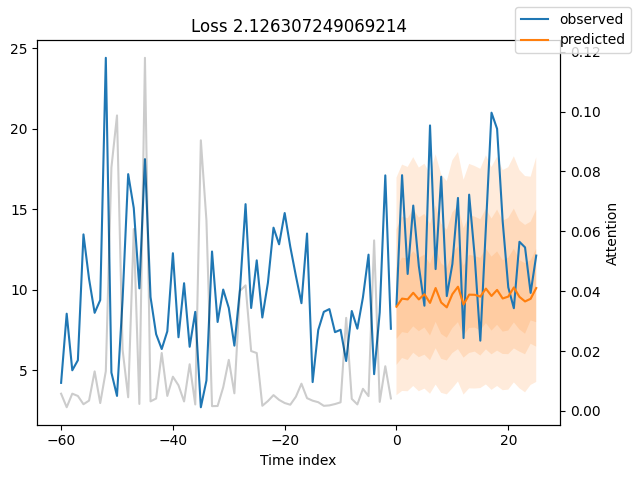

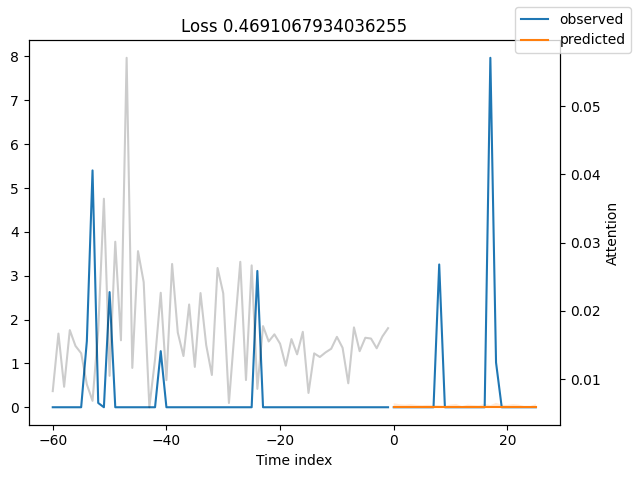

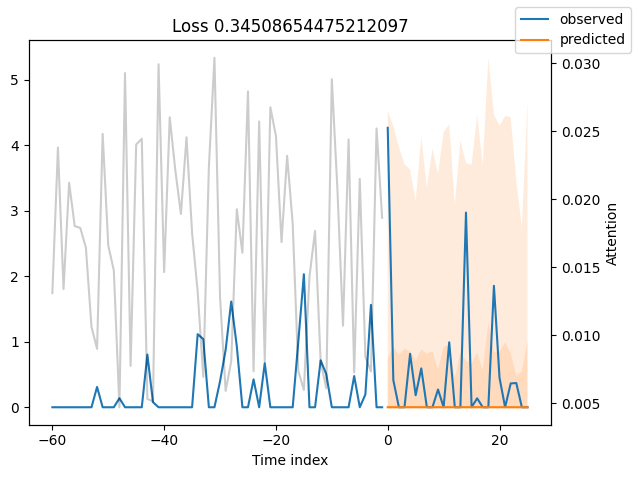

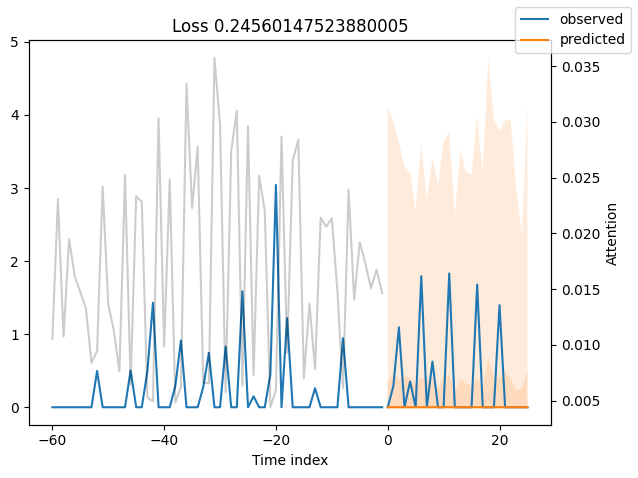

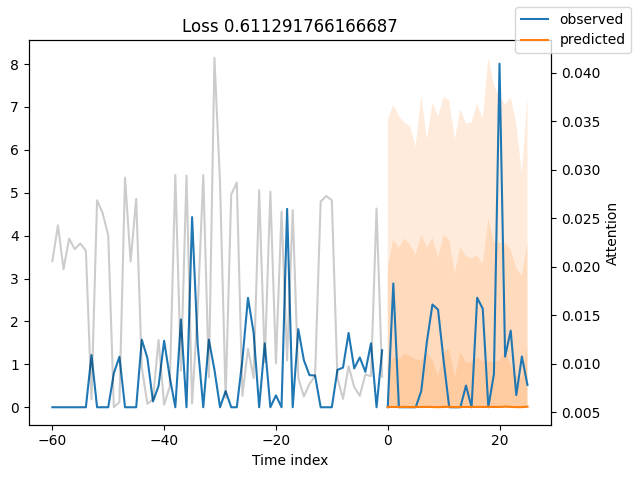

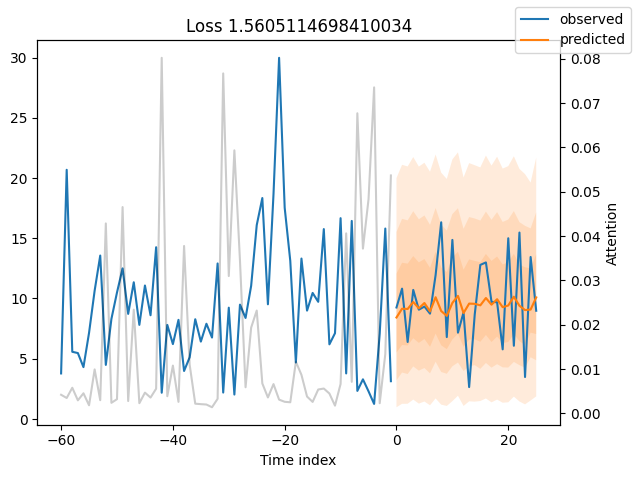

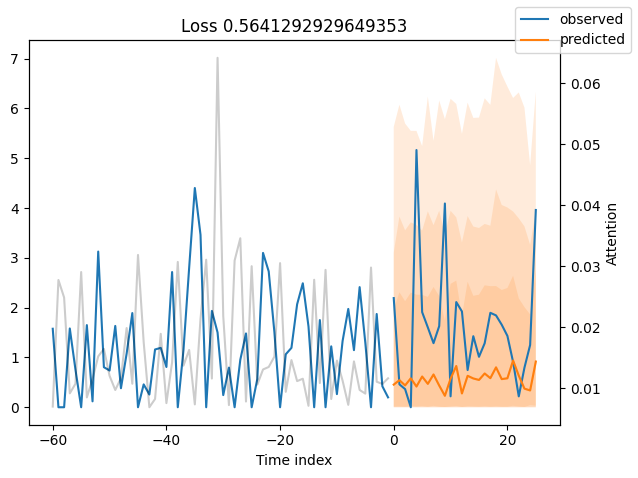

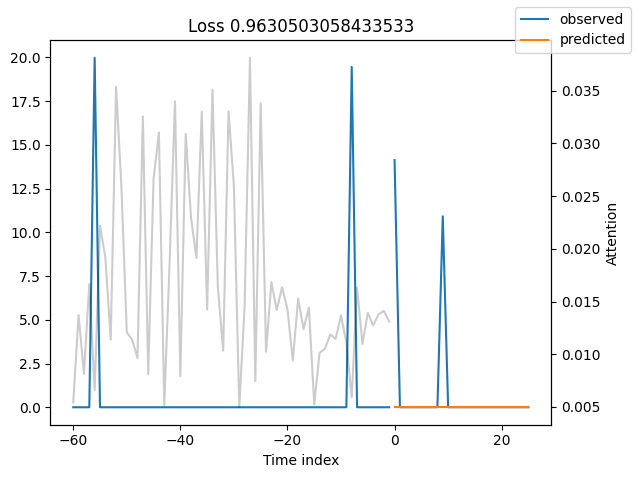

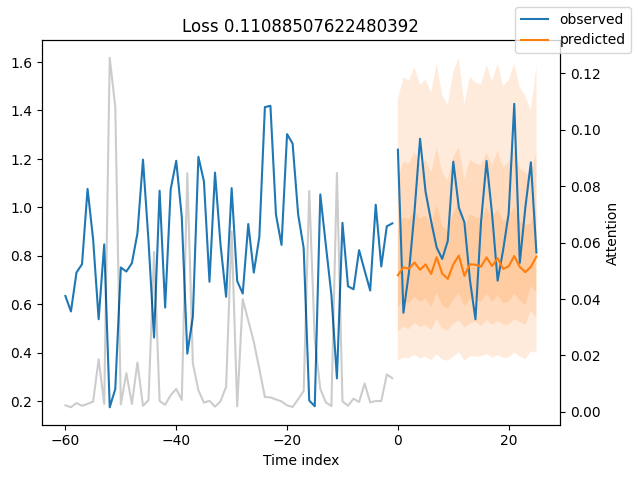

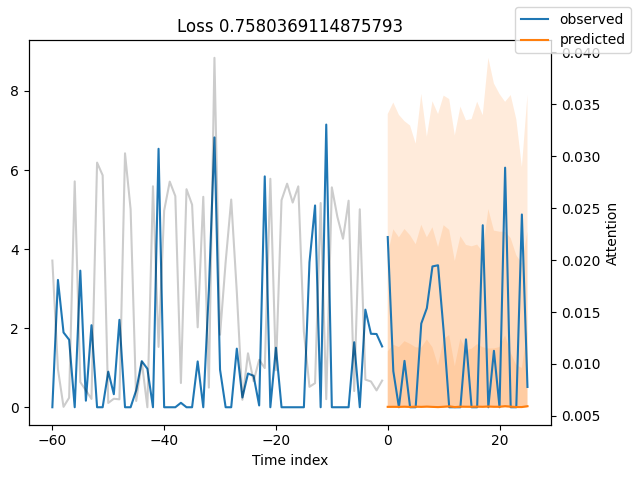

In [15]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10, 20):  # plot 10 examples
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

### Predict 6 months (26 weeks) into the future

In [16]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.week_idx > x.week_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.week_idx == x.week_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(order_datetime=lambda x: x.order_datetime + pd.offsets.Week(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

decoder_data['week_idx'] = (
    (
        decoder_data['order_datetime'] - decoder_data['order_datetime'].min()
    )/np.timedelta64(1, 'W')
).astype(int)
decoder_data["week_idx"] += encoder_data["week_idx"].max() + 1 - decoder_data["week_idx"].min()
# adjust additional time feature(s)
decoder_data["week_of_year"] = decoder_data.order_datetime.dt.isocalendar().week.astype(str) # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

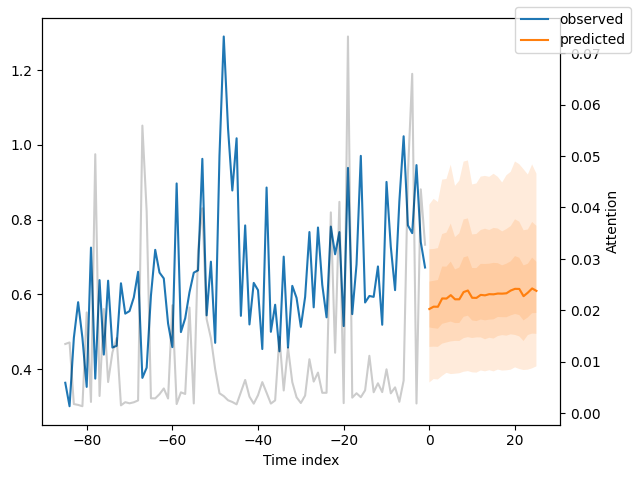

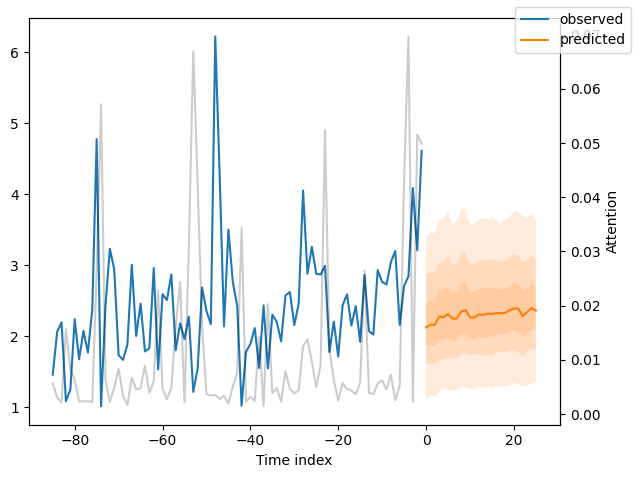

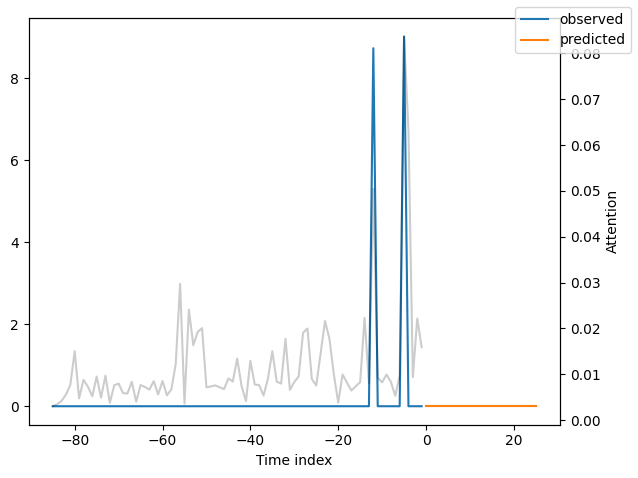

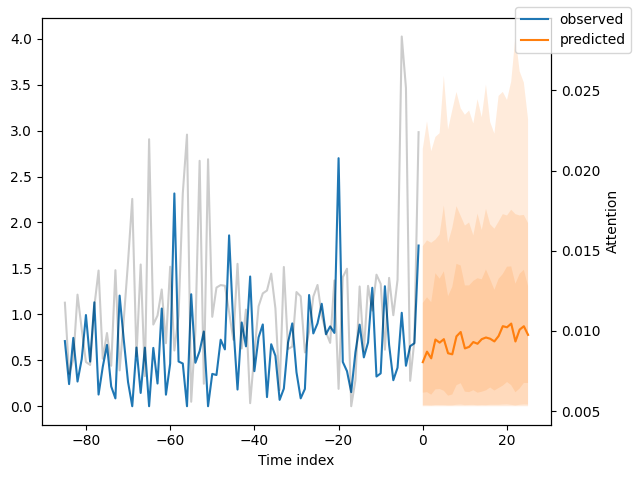

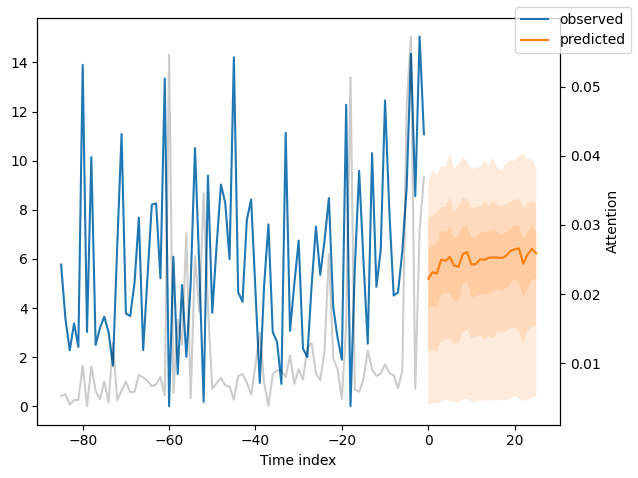

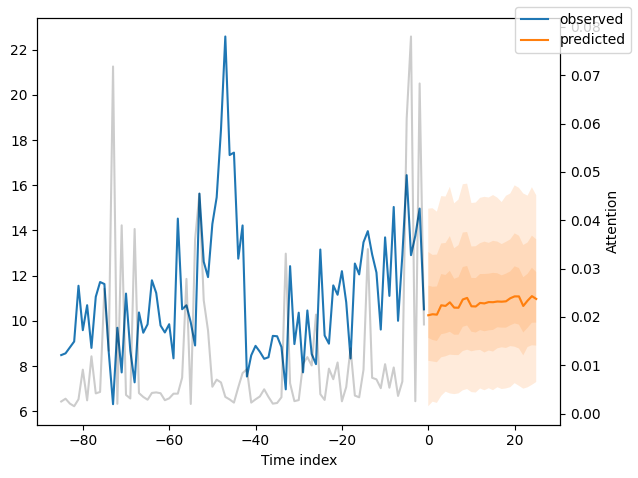

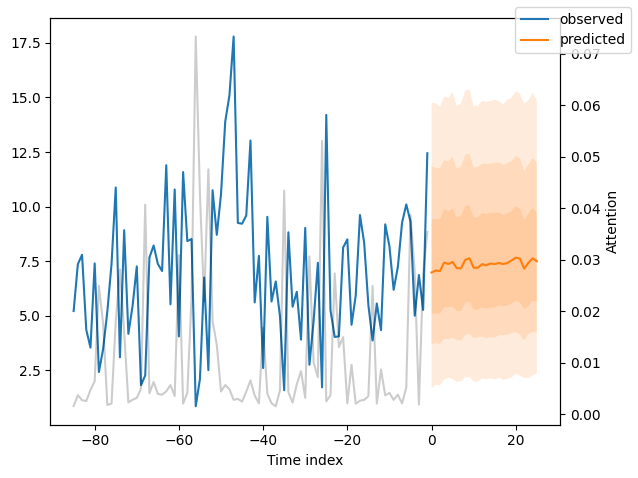

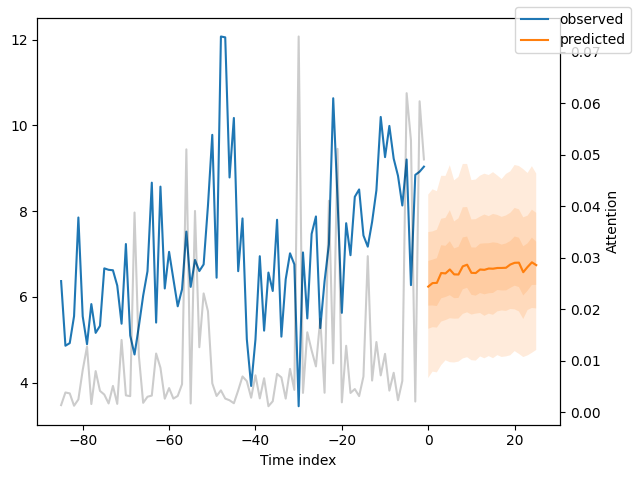

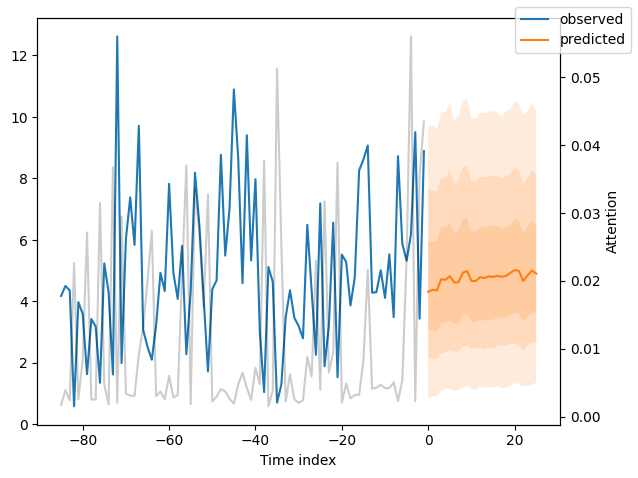

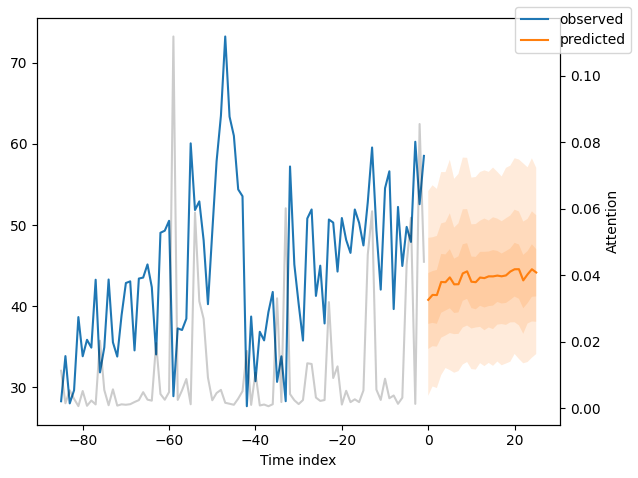

In [18]:
new_raw_predictions, new_x = tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False)

Output predictions to dataframe

In [23]:
predictions, index = tft.predict(new_prediction_data, mode="prediction", return_index=True)

predictions_df = pd.DataFrame(
    predictions.numpy()
).reset_index().melt(
    id_vars = 'index', var_name = 'rel_week_idx'
)

index_df = index.reset_index()

predictions_df = pd.merge(
    index_df,
    predictions_df,
    on = 'index'
)

predictions_df['week_idx'] = predictions_df['week_idx'] + predictions_df['rel_week_idx']

predictions_df = predictions_df.rename(columns = {'index' : 'merchant_idx'}).drop('rel_week_idx', axis = 1)

In [36]:
predictions_df.to_csv('../data/curated/transaction_predictions.parquet')